In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.image as mpimg
from skimage.measure import label, regionprops
from skimage.segmentation import expand_labels, watershed
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

### Remove the first 3 useless rows in the header and save csv files again

In [4]:
# Define the source and destination folders
source_folder = r'\\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\timelapse\tracking\raw_trackmate_export'
destination_folder = r'\\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\timelapse\tracking\cleaned_df'

# List all CSV files in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('.csv'):
        # Full path to the source file
        file_path = os.path.join(source_folder, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Remove the 2nd, 3rd, and 1st rows
        # Note: Indexing is zero-based, so we remove rows 0, 1, and 2
        df_cleaned = df.drop([0, 1, 2])
        
        # Full path to the destination file
        destination_file_path = os.path.join(destination_folder, filename)
        
        # Save the cleaned DataFrame to the destination folder
        df_cleaned.to_csv(destination_file_path, index=False)

print("Processing complete.")

Processing complete.


### Perform diffusion analysis on all csv files and save them again with the track coordinates and Dcoeff for each track

In [5]:
source_folder = r'\\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\timelapse\tracking\cleaned_df'
destination_folder = r'\\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\diffusion_results'

# Define MSD function
def msd_function(t, D, alpha):
    return 4 * D * t**alpha

# Function to calculate MSD values
def calculate_msd(x, y, max_tau):
    N = len(x)
    msd_values = []
    for tau in range(1, max_tau + 1):
        squared_displacements = []
        for i in range(N - tau):
            dx = x[i + tau] - x[i]
            dy = y[i + tau] - y[i]
            squared_displacement = dx**2 + dy**2
            squared_displacements.append(squared_displacement)
        msd_tau = np.mean(squared_displacements)
        msd_values.append(msd_tau)
    return msd_values

# Function to fit MSD data and extract alpha and diffusion coefficient (D)
def calculate_alpha_D(msd_values, time_intervals):
    initial_guess = [1.0, 1.0]
    params, _ = curve_fit(msd_function, time_intervals, msd_values, p0=initial_guess)
    D = params[0]
    alpha = params[1]
    return D, alpha

# Process each CSV file in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(source_folder, filename)
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Group by TRACK_ID and sort by FRAME
        grouped_by_tracks = df.groupby('TRACK_ID')
        ordered_tracks = grouped_by_tracks.apply(lambda x: x.sort_values(by='FRAME')).reset_index(drop=True)
        
        # Add column Time (s) containing the imaging frequency
        ordered_tracks['Time (s)'] = 0.4 + 0.4 * ordered_tracks.groupby('TRACK_ID').cumcount()
        
        # Re-group by TRACK_ID
        grouped_by_tracks = ordered_tracks.groupby('TRACK_ID')
        
        # Calculate MSD and diffusion coefficients
        max_tau = 8
        msd_df = pd.DataFrame(columns=['TRACK_ID', 'MSD', 'time_intervals'])
        coefficients_of_diffusion = []

        for track_id, group in grouped_by_tracks:
            x = group['POSITION_X'].tolist()
            y = group['POSITION_Y'].tolist()
            msd_values = calculate_msd(x, y, max_tau)
            time_intervals = np.arange(1, max_tau + 1) * 0.4
            msd_df = msd_df.append({'TRACK_ID': track_id, 'MSD': msd_values, 'time_intervals': time_intervals}, ignore_index=True)
            diffusion_coefficients = msd_values / (4 * time_intervals)
            for i, d in enumerate(diffusion_coefficients):
                coefficients_of_diffusion.append({'TRACK_ID': track_id, 'MSD_Index': i, 'Diffusion_Coefficient': d})
        
        coefficients_df = pd.DataFrame(coefficients_of_diffusion)
        grouped_diffusion = coefficients_df.groupby('TRACK_ID')['Diffusion_Coefficient'].mean()
        
        # Calculate alpha and D
        def calculate_alpha_row(row):
            alpha = calculate_alpha_D(row['MSD'], row['time_intervals'])[1]
            return alpha

        def calculate_alpha_D_row(row):
            D, alpha = calculate_alpha_D(row['MSD'], row['time_intervals'])
            return pd.Series([D, alpha], index=['D', 'alpha'])

        msd_df['alpha'] = msd_df.apply(calculate_alpha_row, axis=1)
        msd_df[['fitted_D', 'alpha']] = msd_df.apply(calculate_alpha_D_row, axis=1)

        # Classify diffusion types
        normal_df = msd_df[(msd_df['alpha'] > 0.8) & (msd_df['alpha'] < 1.2)]
        super_df = msd_df[(msd_df['alpha'] >= 1.2)]
        confined_df = msd_df[(msd_df['alpha'] <= 0.8)]
        normal_df['type of diffusion'] = 'normal'
        super_df['type of diffusion'] = 'super'
        confined_df['type of diffusion'] = 'confined'
        combined_msd_df = pd.concat([normal_df, super_df, confined_df], ignore_index=True)
        combined_msd_diffusion_df = pd.merge(combined_msd_df, grouped_diffusion, on='TRACK_ID')

        # Save the results
        merged_df = pd.merge(combined_msd_diffusion_df, df, on='TRACK_ID')
        output_file_path = os.path.join(destination_folder, filename)
        merged_df.to_csv(output_file_path, index=False)

print("Processing complete.")


Processing complete.


### For each position, import RB masks, cd24 masks and cd140 masks. Find overlap between masks and classify cells in double negative, cd24+ and cd140 using RB label index. Then using RB labels, find the tracks that belong each label.

In [4]:
# Set the directories
data_dir = r"//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/"
output_dir = r'\\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap'

# Function to get the base name of a file
def get_base_name(filename, suffix):
    return filename.replace(suffix, "")

# List all files in each directory
rb_files = os.listdir(os.path.join(data_dir, 'RB/masks'))
cd24_files = os.listdir(os.path.join(data_dir, 'cd24/masks'))
cd140_files = os.listdir(os.path.join(data_dir, 'cd140/masks'))

# Get the base names
rb_bases = {get_base_name(f, '_RB_mask.tif') for f in rb_files}
cd24_bases = {get_base_name(f, '_cd24_mask.tif') for f in cd24_files}
cd140_bases = {get_base_name(f, '_cd140_mask.tif') for f in cd140_files}

# Find common base names
common_bases = rb_bases & cd24_bases & cd140_bases

# Set the area threshold
threshold = 5000

# Loop through each base name and process the corresponding files
for base_name in common_bases:
    # Read the corresponding masks
    RB_mask = mpimg.imread(os.path.join(data_dir, f'RB/masks/{base_name}_RB_mask.tif'))
    cd140_mask = mpimg.imread(os.path.join(data_dir, f'cd140/masks/{base_name}_cd140_mask.tif'))
    cd24_mask = mpimg.imread(os.path.join(data_dir, f'cd24/masks/{base_name}_cd24_mask.tif'))

    # Label the masks
    label_RB_mask = label(RB_mask)
    label_cd24_mask = label(cd24_mask)
    label_cd140_mask = label(cd140_mask)

    # Calculate the region properties for the RB mask
    RB_props = regionprops(label_RB_mask)

    # Initialize lists to store the information
    labels = []
    areas = []
    cell_types = []

    # Loop through each RB label and only consider those that meet the area threshold
    for prop in RB_props:
        label_id = prop.label
        area = prop.area

        # Only consider regions with area >= threshold
        if area >= threshold:
            labels.append(label_id)
            areas.append(area)

            # Determine overlap with cd24 and cd140 using the filtered regions
            rb_region = (label_RB_mask == label_id)
            overlap_with_cd24 = np.sum(rb_region & (label_cd24_mask > 0)) / np.sum(rb_region)
            overlap_with_cd140 = np.sum(rb_region & (label_cd140_mask > 0)) / np.sum(rb_region)

            # Classify the cell type based on overlap with RB masks (70%)
            if overlap_with_cd24 > 0.7:
                cell_types.append('cd24+')
            elif overlap_with_cd140 > 0.7:
                cell_types.append('cd140+')
            else:
                cell_types.append('double_negative')

    # Create a DataFrame to store the results
    df = pd.DataFrame({
        'RB_Label': labels,
        'Area': areas,
        'Cell_Type': cell_types
    })

    # Define the output path using the base name
    output_path = os.path.join(output_dir, f'{base_name}.csv')

    # Save the DataFrame to a CSV file
    df.to_csv(output_path, index=False)

    print(f"CSV file saved to: {output_path}")

CSV file saved to: \\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap\week2_72h_LIF_rep1_pos001.csv
CSV file saved to: \\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap\week2_72h_RA+_rep2_pos011.csv
CSV file saved to: \\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap\week3_72h_RA+_rep2_pos013.csv
CSV file saved to: \\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap\week1_72h_RA+_rep2_pos010.csv
CSV file saved to: \\bifchem.z.science.ru.nl\bifchem\Projects Hansen\Lab Members folders\CG\Experiments\CHX_CG1\mESCs_differentiation\processed_images\results\labels_overlap\week3_48h_

### Attribute tracks to cells

In [7]:
from skimage.measure import label as skimage_label, regionprops

# Set the directories
data_dir = r"//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/"
output_dir = os.path.join(data_dir, 'results/diffusion_analysis_per_cell_type')

# Function to get the base name of a file
def get_base_name(filename, suffix):
    return filename.replace(suffix, "")

# List all files in each directory
rb_files = os.listdir(os.path.join(data_dir, 'RB/masks'))
cd24_files = os.listdir(os.path.join(data_dir, 'cd24/masks'))
cd140_files = os.listdir(os.path.join(data_dir, 'cd140/masks'))

# Get the base names
rb_bases = {get_base_name(f, '_RB_mask.tif') for f in rb_files}
cd24_bases = {get_base_name(f, '_cd24_mask.tif') for f in cd24_files}
cd140_bases = {get_base_name(f, '_cd140_mask.tif') for f in cd140_files}

# Find common base names
common_bases = rb_bases & cd24_bases & cd140_bases

# Define the area filtering function
def filter_labels_by_area(labeled_image, min_area=5000):
    props = regionprops(labeled_image)
    filtered_image = np.zeros_like(labeled_image)
    for prop in props:
        if prop.area >= min_area:
            filtered_image[labeled_image == prop.label] = prop.label
    return filtered_image

# Set the conversion factor
conversion_factor = 15.4083  # pixels to micrometers

# Loop through each base name and process the corresponding files
for base_name in common_bases:
    # Load the CSV and mask files for the current base name
    df_labels = pd.read_csv(os.path.join(data_dir, f'results/labels_overlap/{base_name}.csv'))
    df_tracks = pd.read_csv(os.path.join(data_dir, f'results/diffusion_results/{base_name}_RB_tl_spots.csv'))
    mask = mpimg.imread(os.path.join(data_dir, f'RB/masks/{base_name}_RB_mask.tif'))

    # Process the mask using skimage_label (renamed alias)
    labeled_mask = skimage_label(mask)
    filtered_mask = filter_labels_by_area(labeled_mask)

    height, width = filtered_mask.shape
    reflected_image = np.flipud(filtered_mask)
    reflected_image_height, reflected_image_width = reflected_image.shape
    reflected_extent_image = [0, reflected_image_width / conversion_factor, 0, reflected_image_height / conversion_factor]

    # Initialize a list to store the track and label overlap information
    track_overlaps = []

    # Iterate over each track in coordinates_df grouped by TRACK_ID
    for track_id, track_data in df_tracks.groupby('TRACK_ID'):
        overlapping_labels = set()
        
        for _, row in track_data.iterrows():
            x_index = int(row['POSITION_X'] * conversion_factor)
            y_index = int(row['POSITION_Y'] * conversion_factor)
            
            if 0 <= x_index < width and 0 <= y_index < height:
                label_at_pixel = filtered_mask[y_index, x_index]
                if label_at_pixel > 0:
                    overlapping_labels.add(label_at_pixel)
        
        for label in overlapping_labels:
            track_overlaps.append({'TRACK_ID': track_id, 'RB_Label': label})

    # Convert the list of overlaps to a DataFrame
    overlap_df = pd.DataFrame(track_overlaps)

    merged_df = pd.merge(overlap_df, df_tracks, on='TRACK_ID')
    merged_df_2 = pd.merge(merged_df, df_labels, on='RB_Label')

    unique_tracks_df = merged_df_2.drop_duplicates(subset='TRACK_ID', keep='first')

    # Select the specified columns
    columns_to_keep = [
        'TRACK_ID', 'alpha', 'MSD', 'time_intervals', 'RB_Label', 
        'type of diffusion', 'Diffusion_Coefficient', 'Area', 'Cell_Type'
    ]

    # Ensure the columns exist in the DataFrame before selecting
    columns_to_keep = [col for col in columns_to_keep if col in unique_tracks_df.columns]

    # Create a new DataFrame with the selected columns
    filtered_df = unique_tracks_df[columns_to_keep]

    # Save the DataFrame to a CSV file
    output_path = os.path.join(output_dir, f'{base_name}.csv')
    filtered_df.to_csv(output_path, index=False)

    print(f"CSV file saved to: {output_path}")


CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/diffusion_analysis_per_cell_type\week2_48h_RA+_rep3_pos020.csv
CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/diffusion_analysis_per_cell_type\week1_72h_RA+_rep2_pos010.csv
CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/diffusion_analysis_per_cell_type\week3_48h_RA+_rep3_pos006.csv
CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/diffusion_analysis_per_cell_type\week3_72h_RA+_rep3_pos002.csv
CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/

### Plot the results

In [2]:
# Define the directory containing the CSV files
data_dir = r"//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/"
input_dir = os.path.join(data_dir, 'results/diffusion_analysis_per_cell_type')

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over each CSV file in the directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        # Extract information from the filename
        base_name = filename.replace('.csv', '')
        parts = base_name.split('_')
        week = parts[0]
        time_point = parts[1]
        condition = parts[2]
        replicate = parts[3]
        position = parts[4]

        # Load the current CSV file into a DataFrame
        file_path = os.path.join(input_dir, filename)
        df = pd.read_csv(file_path)

        # Add the new columns
        df['week'] = week
        df['time_point'] = time_point
        df['condition'] = condition
        df['replicate'] = replicate
        df['position'] = position

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Define the output path for the combined CSV
output_path = os.path.join(data_dir, 'results/results_combined/all_results.csv')

# Save the combined DataFrame to a CSV file
combined_df.to_csv(output_path, index=False)

print(f"Combined CSV file saved to: {output_path}")


Combined CSV file saved to: //bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/results_combined/all_results.csv


In [3]:
data_dir = r"//bifchem.z.science.ru.nl/bifchem/Projects Hansen/Lab Members folders/CG/Experiments/CHX_CG1/mESCs_differentiation/processed_images/results/results_combined/"
combined_df = pd.read_csv(data_dir + 'all_results.csv')

In [4]:
# Group the data by the specified columns and calculate the mean of Diffusion_Coefficient
grouped_df = combined_df.groupby(['week', 'time_point', 'replicate', 'condition', 'Cell_Type', 'type of diffusion']).agg({
    'Diffusion_Coefficient': 'mean'
}).reset_index()

### Plot each different experiment with the sem of the replicates from the same replicate

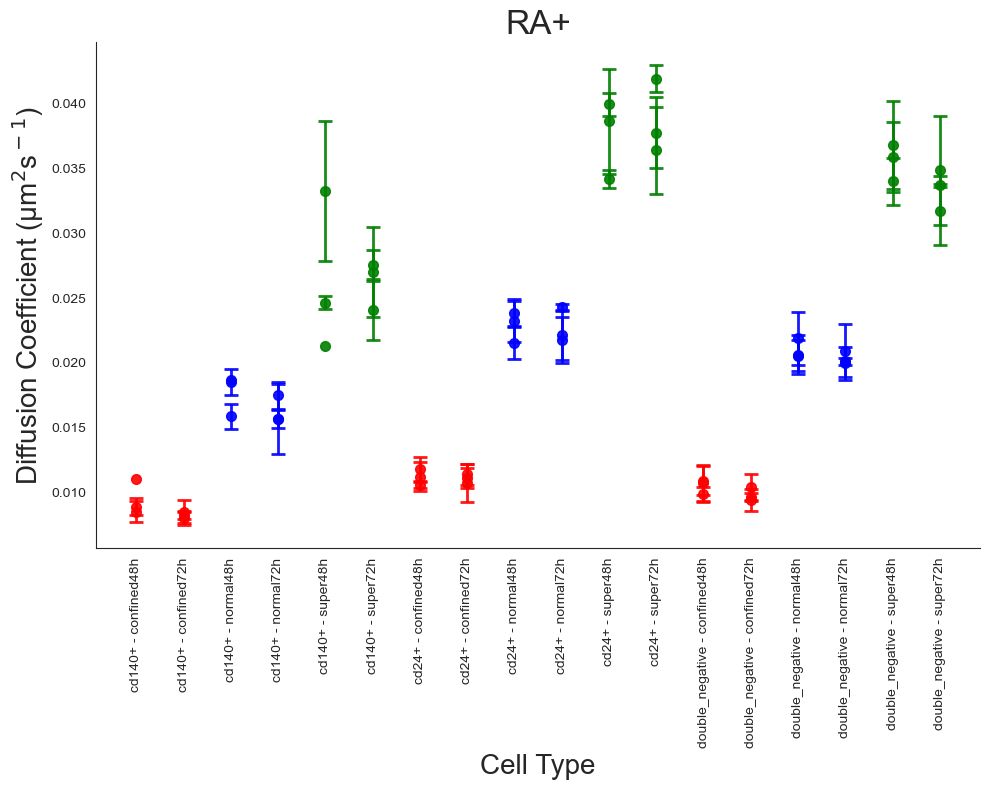

In [5]:

# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion'] + filtered_df['time_point']

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point', 'week']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point']):
    # Ensure that different time_points get different markers
    for i, (time_point, time_group) in enumerate(group.groupby('time_point')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
plt.title('RA+', fontsize=24)
plt.xlabel('Cell Type', fontsize=20)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

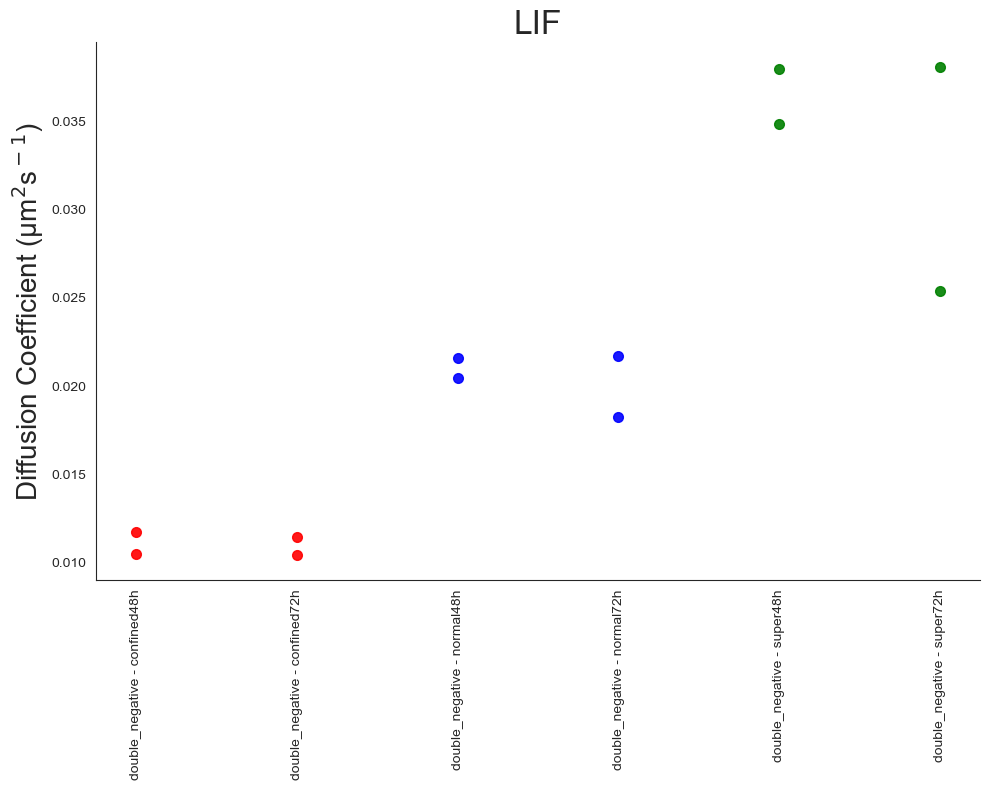

In [27]:

# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'LIF')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion'] + filtered_df['time_point']

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point', 'week']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point']):
    # Ensure that different time_points get different markers
    for i, (time_point, time_group) in enumerate(group.groupby('time_point')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
#plt.title('Mean Diffusion Coefficient with SEM for Different Diffusion Types')
plt.title('LIF', fontsize=24)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

### Plot each different experiment with the sem of the replicates from the same replicate combining LIF and RA+

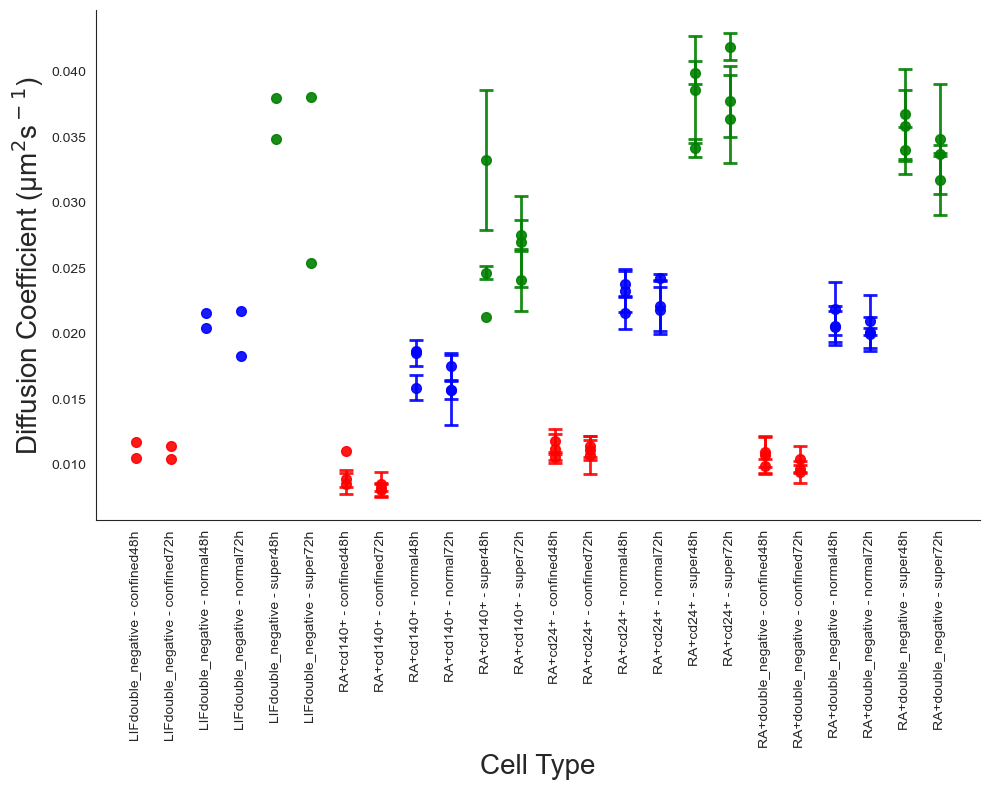

In [6]:

# Filter the DataFrame
#filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
grouped_df['Cell_Type_Diffusion_time'] = grouped_df['condition'] + grouped_df['Cell_Type'] + ' - ' + grouped_df['type of diffusion'] + grouped_df['time_point']

# Group by the necessary columns and calculate mean and SEM
agg_df = grouped_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point', 'week', 'condition']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'time_point', 'condition']):
    # Ensure that different time_points get different markers
    for i, (time_point, time_group) in enumerate(group.groupby('time_point')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
#plt.title('RA+', fontsize=24)
plt.xlabel('Cell Type', fontsize=20)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

### Plot each different experiment with the sem of the replicates from only one time point

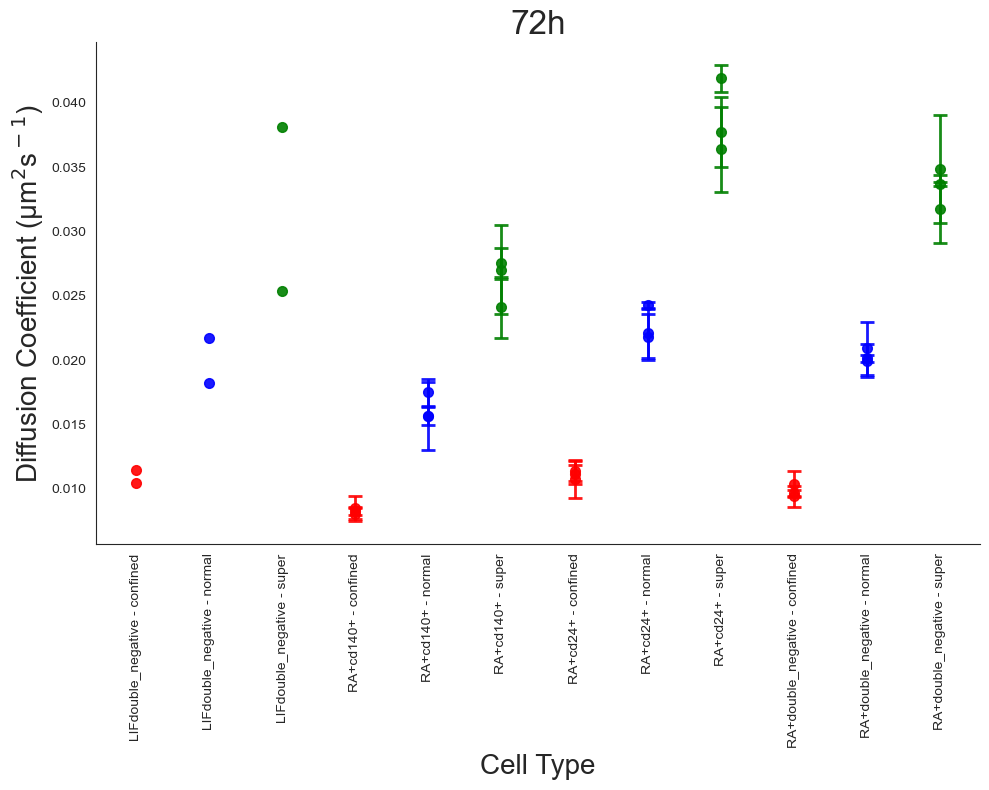

In [7]:

# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['time_point'] == '72h')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'week', 'condition']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition']):
    # Ensure that different time_points get different markers
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
plt.title('72h', fontsize=24)
plt.xlabel('Cell Type', fontsize=20)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

### Plot the average of all experiments with the sem for a single timepoint

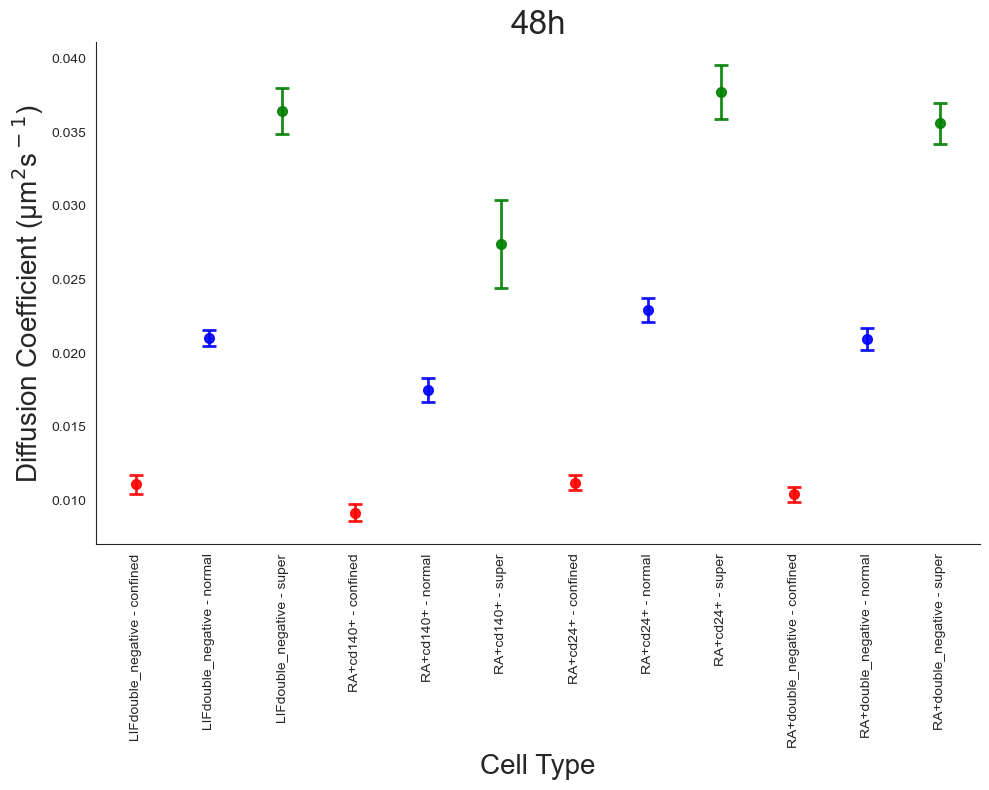

In [8]:

# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['time_point'] == '48h')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition']):
    # Ensure that different time_points get different markers
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
plt.title('48h', fontsize=24)
plt.xlabel('Cell Type', fontsize=20)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

### Plot the average of all experiments and timepoints with the sem

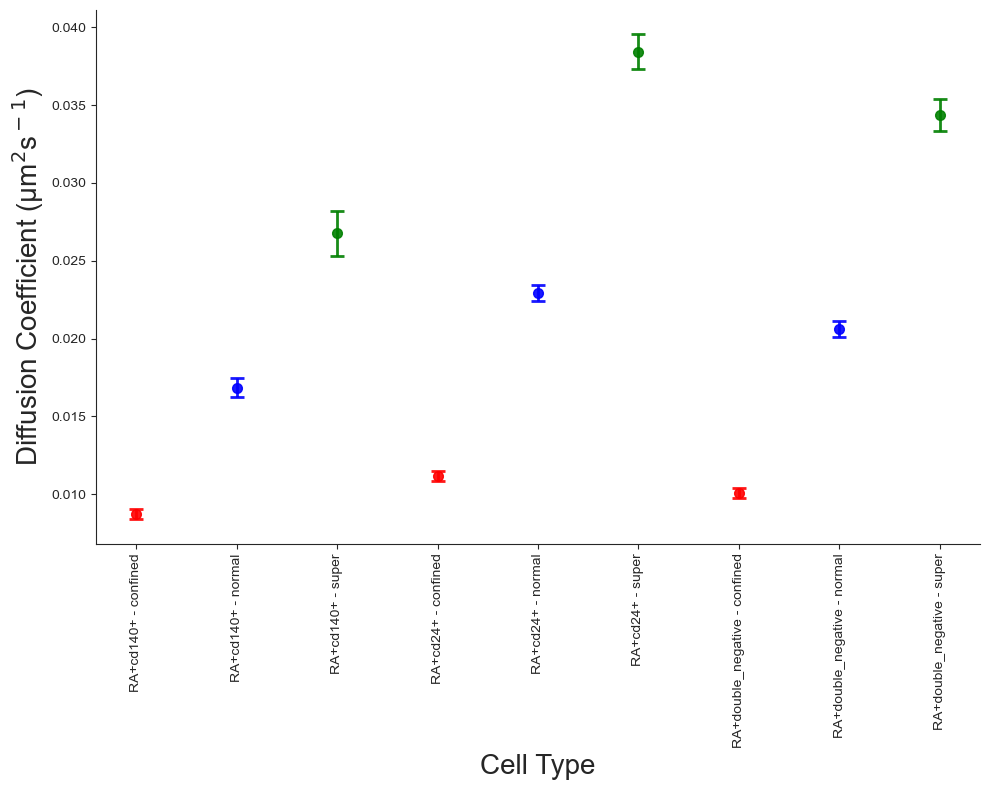

In [31]:

# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]

# Add a new column combining Cell_Type and type_of_diffusion for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define a color mapping for the type of diffusion
color_map = {
    'confined': 'red',
    'normal': 'blue',
    'super': 'green'
}

# Define marker styles
markers = ['o', 'x']

# Set up the plotting area
plt.figure(figsize=(10, 8))
sns.set_style("ticks")

# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition']):
    # Ensure that different time_points get different markers
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'],
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[i % len(markers)],  # Use different markers for each time_point
            color=color_map[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=7,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )


# Customize the plot
#plt.title('48h', fontsize=24)
plt.xlabel('Cell Type', fontsize=20)
plt.ylabel('Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=20)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

plt.show()

### Plot the average for each timepoint of the same week and different time point

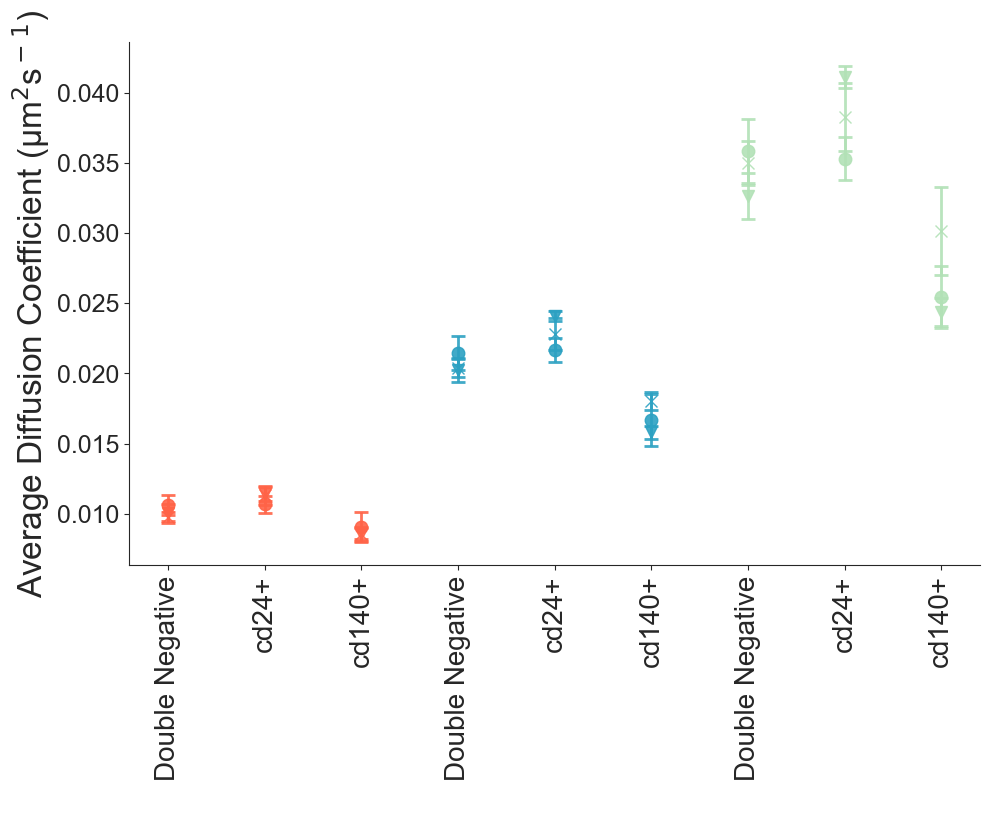

In [32]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
    
plt.style.use('style.mplstyle.txt')


# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]

# Add a new column combining Cell_Type, type_of_diffusion, and condition for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Define the custom order for x-axis
custom_order = [
    'RA+double_negative - confined',
    'RA+cd24+ - confined',
    'RA+cd140+ - confined',
    'RA+double_negative - normal',
    'RA+cd24+ - normal',
    'RA+cd140+ - normal',
    'RA+double_negative - super',
    'RA+cd24+ - super',
    'RA+cd140+ - super'

]

# Convert 'Cell_Type_Diffusion_time' to a categorical variable with the custom order
filtered_df['Cell_Type_Diffusion_time'] = pd.Categorical(filtered_df['Cell_Type_Diffusion_time'], categories=custom_order, ordered=True)

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define colors and markers
color_palette = sns.color_palette("YlGnBu")
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}
markers = {'week1': 'o', 'week2': 'x', 'week3': 'v'}

# Set up the plotting area
plt.figure(figsize=(10, 8))


# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']):
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'].cat.codes,  # Use categorical codes for x-axis positions
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[group['week'].iloc[0]],  # Use different markers for each week
            color=colors[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=9,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )
        
labels=["Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+"]
# Set custom x-ticks
plt.xticks(ticks=np.arange(len(custom_order)), labels=labels, rotation=90, fontsize=20)
plt.yticks(fontsize=18)
# Customize the plot
plt.xlabel(' ', fontsize=20)
plt.ylabel('Average Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=24)

sns.despine()
plt.tight_layout()
plt.savefig(data_dir + 'DCoeff_lineages_RA+.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

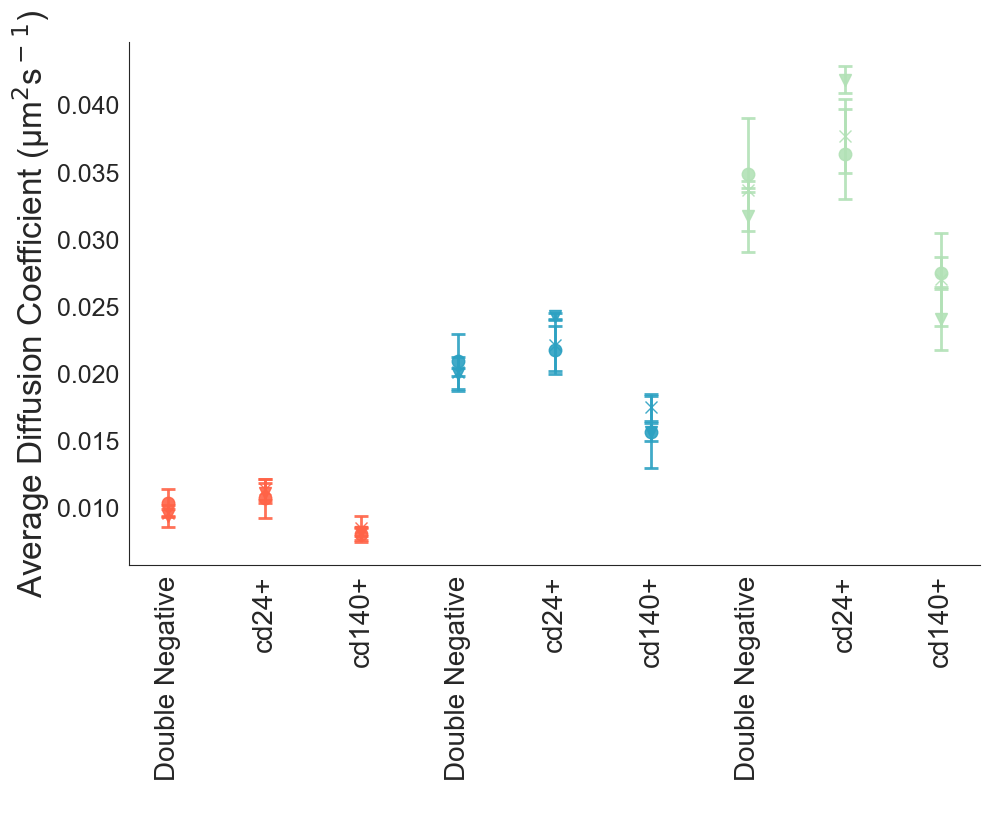

In [15]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
    
plt.style.use('style.mplstyle.txt')


# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]
filtered_df = filtered_df[(filtered_df['time_point'] == '72h')]
# Add a new column combining Cell_Type, type_of_diffusion, and condition for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Define the custom order for x-axis
custom_order = [
    'RA+double_negative - confined',
    'RA+cd24+ - confined',
    'RA+cd140+ - confined',
    'RA+double_negative - normal',
    'RA+cd24+ - normal',
    'RA+cd140+ - normal',
    'RA+double_negative - super',
    'RA+cd24+ - super',
    'RA+cd140+ - super'

]

# Convert 'Cell_Type_Diffusion_time' to a categorical variable with the custom order
filtered_df['Cell_Type_Diffusion_time'] = pd.Categorical(filtered_df['Cell_Type_Diffusion_time'], categories=custom_order, ordered=True)

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']).agg(
    mean_diffusion_coefficient=('Diffusion_Coefficient', 'mean'),
    sem_diffusion_coefficient=('Diffusion_Coefficient', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Define colors and markers
color_palette = sns.color_palette("YlGnBu")
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}
markers = {'week1': 'o', 'week2': 'x', 'week3': 'v'}

# Set up the plotting area
plt.figure(figsize=(10, 8))


# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']):
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'].cat.codes,  # Use categorical codes for x-axis positions
            y=time_group['mean_diffusion_coefficient'],
            yerr=time_group['sem_diffusion_coefficient'],
            fmt=markers[group['week'].iloc[0]],  # Use different markers for each week
            color=colors[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=9,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )
        
labels=["Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+"]
# Set custom x-ticks
plt.xticks(ticks=np.arange(len(custom_order)), labels=labels, rotation=90, fontsize=20)
plt.yticks(fontsize=18)
# Customize the plot
plt.xlabel(' ', fontsize=20)
plt.ylabel('Average Diffusion Coefficient (µm$^2$s$^-$$^1$)', fontsize=24)

sns.despine()
plt.tight_layout()
plt.savefig(data_dir + 'DCoeff_lineages_RA+_72h.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Plot % of tracks for each cell type, combibining all experiments and timepoints

In [36]:
# Calculate the percentage of each type of diffusion within each group
grouped = combined_df.groupby(['condition', 'Cell_Type', 'type of diffusion', 'week', 'time_point']).size().reset_index(name='count')
grouped['total'] = grouped.groupby(['condition', 'Cell_Type', 'week', 'time_point'])['count'].transform('sum')
grouped['percentage'] = (grouped['count'] / grouped['total']) * 100

# Calculate mean and std for each type of diffusion across replicates for each cell line
summary = grouped.groupby(['Cell_Type', 'type of diffusion', 'condition', 'time_point']).agg(
    mean_percentage=('percentage', 'mean'),
    std_percentage=('percentage', 'std')
).reset_index()


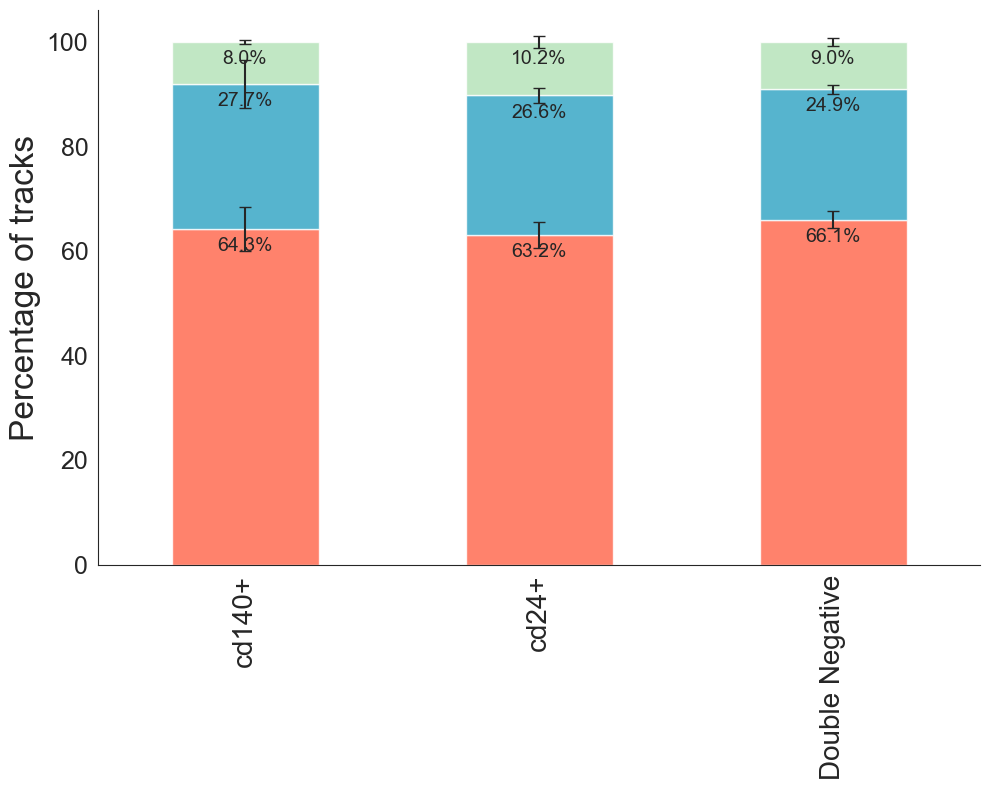

In [37]:
# Assuming summary DataFrame is properly loaded and filtered
summary = summary[(summary['condition'] == 'RA+')]
summary = summary[(summary['time_point'] == '48h')]
# Set up the plot style
plt.style.use('style.mplstyle.txt')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plotting the stacked bar chart
#plt.figure(figsize=(10, 8))  # Ensure figure size is set correctly

color_palette = sns.color_palette("YlGnBu")
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}

# Pivoting data for plotting
summary_pivot = summary.pivot(index='Cell_Type', columns='type of diffusion', values='mean_percentage')
summary_std_pivot = summary.pivot(index='Cell_Type', columns='type of diffusion', values='std_percentage')

# Create the stacked bar plot
ax = summary_pivot.plot(kind='bar', stacked=True, yerr=summary_std_pivot, capsize=4, alpha=0.8,
                        color=[colors.get(col, 'grey') for col in summary_pivot.columns], figsize=(10, 8) )

# Annotate bars with percentage mean
for i, cell_line in enumerate(summary_pivot.index):
    heights = summary_pivot.loc[cell_line].cumsum()  # Get cumulative heights for stacking
    for j, diffusion_type in enumerate(summary_pivot.columns):
        height = heights[j]  # Current height
        if height > 0:  # Add text if height is non-zero
            ax.text(i, height - 5, f'{summary_pivot.loc[cell_line, diffusion_type]:.1f}%', 
                    ha='center', va='bottom', fontsize=14)

# Adjust labels and title
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Percentage of tracks', fontsize=24)
plt.yticks(fontsize=18)
labels = ["cd140+", "cd24+", "Double Negative"]
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90, fontsize=20)

# Remove legend if not needed
ax.get_legend().remove()

# Final layout adjustment
plt.tight_layout()
sns.despine()  # Remove the top and right spines

# Save the figure
plt.savefig(data_dir + 'Percentages_lineages_RA+_48h.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Show the figure
plt.show()


### Check correlations with total cell area

In [42]:
# Group the data by the specified columns and calculate the mean of Diffusion_Coefficient
grouped_df = combined_df.groupby(['week', 'condition', 'Cell_Type', 'type of diffusion']).agg({
    'Diffusion_Coefficient': 'mean', 'Area':'mean',
}).reset_index()

In [43]:
# Filter the DataFrame
filtered_df = grouped_df[(grouped_df['condition'] == 'RA+')]

filtered_df['Area_um2'] = filtered_df['Area']*0.00421

In [44]:
filtered_df

,week,condition,Cell_Type,type of diffusion,Diffusion_Coefficient,Area,Area_um2
0,week1,RA+,cd140+,confined,0.008479,39154.004800,164.838360
1,week1,RA+,cd140+,normal,0.017143,37916.608939,159.628924
2,week1,RA+,cd140+,super,0.027249,37033.960000,155.912972
3,week1,RA+,cd24+,confined,0.010638,24825.017760,104.513325
4,week1,RA+,cd24+,normal,0.021731,24396.651992,102.709905
5,week1,RA+,cd24+,super,0.036123,24281.493660,102.225088
6,week1,RA+,double_negative,confined,0.010316,34171.436131,143.861746
7,week1,RA+,double_negative,normal,0.021200,34149.348002,143.768755
8,week1,RA+,double_negative,super,0.035788,34240.777107,144.153672
12,week2,RA+,cd140+,confined,0.008909,64012.683240,269.493396


In [47]:
# Grouping by 'Cell_Type' and 'type of diffusion' and calculating the mean and SEM for 'Diffusion_Coefficient' and 'Area_um2'
grouped_df_2 = filtered_df.groupby(['Cell_Type', 'type of diffusion', 'week']).agg({
    'Diffusion_Coefficient': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))],
    'Area_um2': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}).reset_index()

grouped_df_2

Cell_Type type of diffusion   week Diffusion_Coefficient             \
                                                              mean <lambda_0>   
0            cd140+          confined  week1              0.008479        NaN   
1            cd140+          confined  week2              0.008909        NaN   
2            cd140+          confined  week3              0.008433        NaN   
3            cd140+            normal  week1              0.017143        NaN   
4            cd140+            normal  week2              0.017632        NaN   
5            cd140+            normal  week3              0.015829        NaN   
6            cd140+             super  week1              0.027249        NaN   
7            cd140+             super  week2              0.027830        NaN   
8            cd140+             super  week3              0.025164        NaN   
9             cd24+          confined  week1              0.010638        NaN   
10            cd24+          confined  week2              0.011123        NaN   
11            cd24+          confined  week3              0.011377        NaN   
12            cd24+            normal  week1              0.021731        NaN   
13            cd24+            normal  week2              0.021533        NaN   
14            cd24+            normal  week3              0.023957        NaN   
15            cd24+             super  week1              0.036123        NaN   
16            cd24+             super  week2              0.036740        NaN   
17            cd24+             super  week3              0.040915        NaN   
18  double_negative          confined  week1              0.010316        NaN   
19  double_negative          confined  week2              0.009869        NaN   
20  double_negative          confined  week3              0.010012        NaN   
21  double_negative            normal  week1              0.021200        NaN   
22  double_negative            normal  week2              0.020661        NaN   
23  double_negative            normal  week3              0.020289        NaN   
24  double_negative             super  week1              0.035788        NaN   
25  double_negative             super  week2              0.035832        NaN   
26  double_negative             super  week3              0.032921        NaN   

      Area_um2             
          mean <lambda_0>  
0   164.838360        NaN  
1   269.493396        NaN  
2   242.603667        NaN  
3   159.628924        NaN  
4   264.793894        NaN  
5   243.235534        NaN  
6   155.912972        NaN  
7   263.086291        NaN  
8   240.284214        NaN  
9   104.513325        NaN  
10   90.253748        NaN  
11  123.520915        NaN  
12  102.709905        NaN  
13   91.240800        NaN  
14  120.065294        NaN  
15  102.225088        NaN  
16   91.539559        NaN  
17  116.861588        NaN  
18  143.861746        NaN  
19  180.859331        NaN  
20  194.526124        NaN  
21  143.768755        NaN  
22  172.077318        NaN  
23  190.488534        NaN  
24  144.153672        NaN  
25  163.820283        NaN  
26  184.432107        NaN

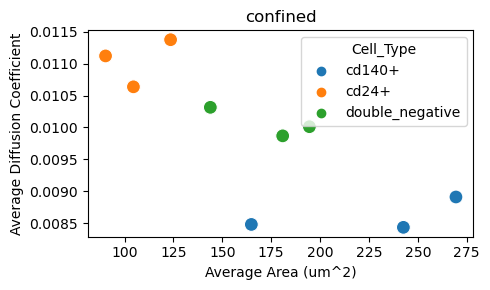

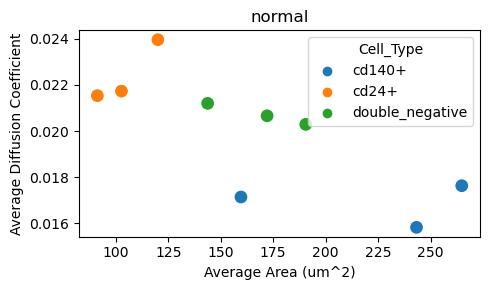

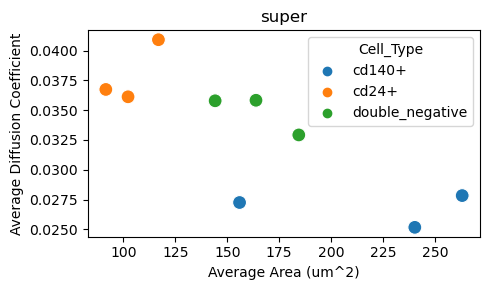

In [48]:
# Grouping by 'Cell_Type' and 'type of diffusion' and calculating the mean and SEM for 'Diffusion_Coefficient' and 'Area_um2'
grouped_df_2 = filtered_df.groupby(['Cell_Type', 'type of diffusion', 'week']).agg({
    'Diffusion_Coefficient': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))],
    'Area_um2': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}).reset_index()

# Flatten the MultiIndex columns
grouped_df_2.columns = ['Cell_Type', 'type of diffusion', 'week','Diffusion_Coefficient_mean', 'Diffusion_Coefficient_sem', 'Area_um2_mean', 'Area_um2_sem']

# Get the unique types of diffusion
diffusion_types = grouped_df_2['type of diffusion'].unique()

for diffusion_type in diffusion_types:
    # Filter the dataframe for the current type of diffusion
    diffusion_df = grouped_df_2[grouped_df_2['type of diffusion'] == diffusion_type]
    
    # Set up the figure and axes
    plt.figure(figsize=(5, 3))
    
    # First plot the error bars
    plt.errorbar(
        x=diffusion_df['Area_um2_mean'], 
        y=diffusion_df['Diffusion_Coefficient_mean'], 
        #xerr=diffusion_df['Area_um2_sem'], 
        yerr=diffusion_df['Diffusion_Coefficient_sem'], 
        fmt='none',  # 'none' means no marker will be drawn by errorbar
        ecolor='gray',  # Error bar color
        elinewidth=1,   # Error bar line width
        capsize=3       # Error bar cap size
    )
    
    # Then plot the scatter plot
    sns.scatterplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', hue='Cell_Type', s=100)
    
    # Adding labels and title
    plt.xlabel('Average Area (um^2)')
    plt.ylabel('Average Diffusion Coefficient')
    plt.title(f'{diffusion_type}')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

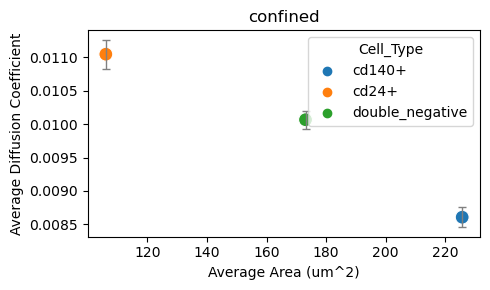

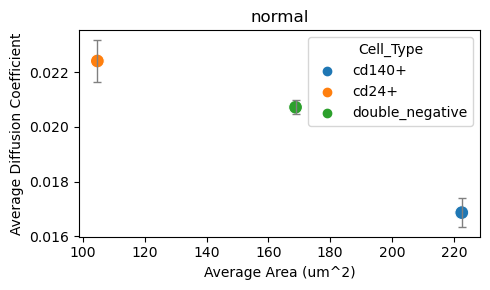

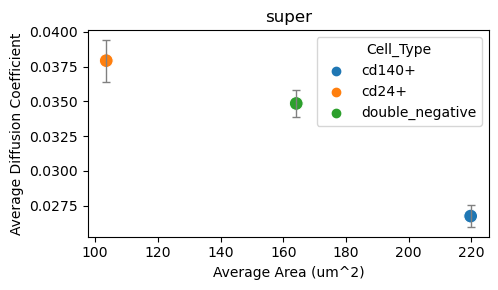

In [49]:
   # Grouping by 'Cell_Type' and 'type of diffusion' and calculating the mean and SEM for 'Diffusion_Coefficient' and 'Area_um2'
grouped_df_2 = filtered_df.groupby(['Cell_Type', 'type of diffusion',]).agg({
    'Diffusion_Coefficient': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))],
    'Area_um2': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}).reset_index()

# Flatten the MultiIndex columns
grouped_df_2.columns = ['Cell_Type', 'type of diffusion', 'Diffusion_Coefficient_mean', 'Diffusion_Coefficient_sem', 'Area_um2_mean', 'Area_um2_sem']

# Get the unique types of diffusion
diffusion_types = grouped_df_2['type of diffusion'].unique()

for diffusion_type in diffusion_types:
    # Filter the dataframe for the current type of diffusion
    diffusion_df = grouped_df_2[grouped_df_2['type of diffusion'] == diffusion_type]
    
    # Set up the figure and axes
    plt.figure(figsize=(5, 3))
    
    # First plot the error bars
    plt.errorbar(
        x=diffusion_df['Area_um2_mean'], 
        y=diffusion_df['Diffusion_Coefficient_mean'], 
        #xerr=diffusion_df['Area_um2_sem'], 
        yerr=diffusion_df['Diffusion_Coefficient_sem'], 
        fmt='none',  # 'none' means no marker will be drawn by errorbar
        ecolor='gray',  # Error bar color
        elinewidth=1,   # Error bar line width
        capsize=3       # Error bar cap size
    )
    
    # Then plot the scatter plot
    sns.scatterplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', hue='Cell_Type', s=100)
    
    # Adding labels and title
    plt.xlabel('Average Area (um^2)')
    plt.ylabel('Average Diffusion Coefficient')
    plt.title(f'{diffusion_type}')
    
    # Show the plot
    plt.tight_layout()
    plt.show() 


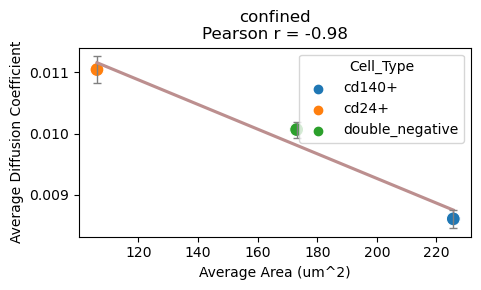

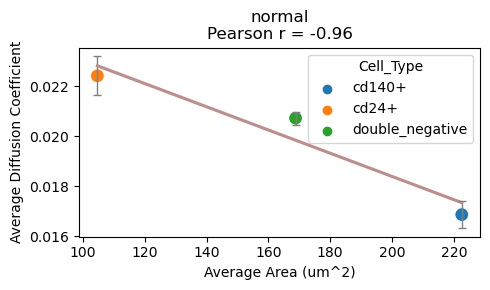

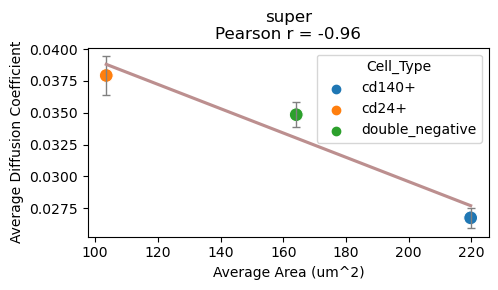

In [52]:
from scipy.stats import pearsonr

# Assuming filtered_df is your DataFrame
# Grouping by 'Cell_Type' and 'type of diffusion' and calculating the mean and SEM for 'Diffusion_Coefficient' and 'Area_um2'
grouped_df_2 = filtered_df.groupby(['Cell_Type', 'type of diffusion']).agg({
    'Diffusion_Coefficient': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))],
    'Area_um2': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}).reset_index()

# Flatten the MultiIndex columns
grouped_df_2.columns = ['Cell_Type', 'type of diffusion', 'Diffusion_Coefficient_mean', 'Diffusion_Coefficient_sem', 'Area_um2_mean', 'Area_um2_sem']

# Get the unique types of diffusion
diffusion_types = grouped_df_2['type of diffusion'].unique()

for diffusion_type in diffusion_types:
    # Filter the dataframe for the current type of diffusion
    diffusion_df = grouped_df_2[grouped_df_2['type of diffusion'] == diffusion_type]
    
    # Calculate Pearson correlation coefficient
    pearson_r, p_value = pearsonr(diffusion_df['Area_um2_mean'], diffusion_df['Diffusion_Coefficient_mean'])
    
    # Set up the figure and axes
    plt.figure(figsize=(5, 3))
    
    # Plot the regression line with scatter plot
    sns.regplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', 
                        scatter_kws={'s': 50, 'color': 'black'},  # Size and color of scatter points
                    line_kws={'color': 'rosybrown'}, scatter=True, fit_reg=True, ci=None)
    
     
   
    
    # First plot the error bars
    plt.errorbar(
        x=diffusion_df['Area_um2_mean'], 
        y=diffusion_df['Diffusion_Coefficient_mean'], 
        #xerr=diffusion_df['Area_um2_sem'], 
        yerr=diffusion_df['Diffusion_Coefficient_sem'], 
        fmt='none',  # 'none' means no marker will be drawn by errorbar
        ecolor='gray',  # Error bar color
        elinewidth=1,   # Error bar line width
        capsize=3       # Error bar cap size
    )
    
    sns.scatterplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', hue='Cell_Type', s=100)  
    
    # Adding labels and title
    plt.xlabel('Average Area (um^2)')
    plt.ylabel('Average Diffusion Coefficient')
    plt.title(f'{diffusion_type}\nPearson r = {pearson_r:.2f}')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


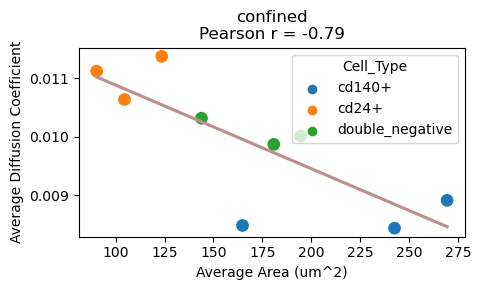

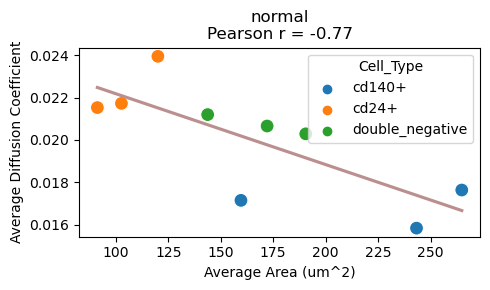

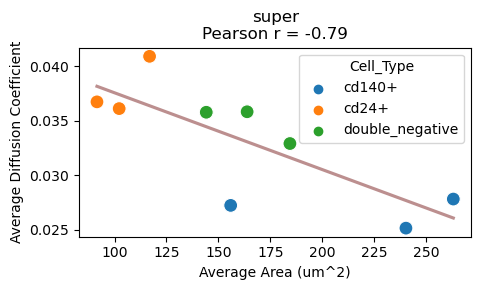

In [50]:
from scipy.stats import pearsonr

# Assuming filtered_df is your DataFrame
# Grouping by 'Cell_Type' and 'type of diffusion' and calculating the mean and SEM for 'Diffusion_Coefficient' and 'Area_um2'
grouped_df_2 = filtered_df.groupby(['Cell_Type', 'type of diffusion', 'week']).agg({
    'Diffusion_Coefficient': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))],
    'Area_um2': ['mean', lambda x: np.std(x, ddof=1) / np.sqrt(len(x))]
}).reset_index()

# Flatten the MultiIndex columns
grouped_df_2.columns = ['Cell_Type', 'type of diffusion', 'week', 'Diffusion_Coefficient_mean', 'Diffusion_Coefficient_sem', 'Area_um2_mean', 'Area_um2_sem']

# Get the unique types of diffusion
diffusion_types = grouped_df_2['type of diffusion'].unique()

for diffusion_type in diffusion_types:
    # Filter the dataframe for the current type of diffusion
    diffusion_df = grouped_df_2[grouped_df_2['type of diffusion'] == diffusion_type]
    
    # Calculate Pearson correlation coefficient
    pearson_r, p_value = pearsonr(diffusion_df['Area_um2_mean'], diffusion_df['Diffusion_Coefficient_mean'])
    
    # Set up the figure and axes
    plt.figure(figsize=(5, 3))
    
    # Plot the regression line with scatter plot
    sns.regplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', 
                        scatter_kws={'s': 50, 'color': 'black'},  # Size and color of scatter points
                    line_kws={'color': 'rosybrown'}, scatter=True, fit_reg=True, ci=None)
    
     
   
    
    # First plot the error bars
    plt.errorbar(
        x=diffusion_df['Area_um2_mean'], 
        y=diffusion_df['Diffusion_Coefficient_mean'], 
        #xerr=diffusion_df['Area_um2_sem'], 
        yerr=diffusion_df['Diffusion_Coefficient_sem'], 
        fmt='none',  # 'none' means no marker will be drawn by errorbar
        ecolor='gray',  # Error bar color
        elinewidth=1,   # Error bar line width
        capsize=3       # Error bar cap size
    )
    
    sns.scatterplot(data=diffusion_df, x='Area_um2_mean', y='Diffusion_Coefficient_mean', hue='Cell_Type', s=100)  
    
    # Adding labels and title
    plt.xlabel('Average Area (um^2)')
    plt.ylabel('Average Diffusion Coefficient')
    plt.title(f'{diffusion_type}\nPearson r = {pearson_r:.2f}')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [33]:
# Group the data by the specified columns and calculate the mean of Diffusion_Coefficient
grouped_df = combined_df.groupby(['week', 'time_point', 'replicate', 'RB_Label', 'condition', 'Cell_Type', 'type of diffusion']).agg({
    'Diffusion_Coefficient': 'mean'
}).reset_index()

In [40]:
# Group by 'cell_line' and 'type_of_diffusion' and calculate mean and variance of 'Diffusion_Coefficient'
grouped = grouped_df.groupby(['week', 'time_point', 'replicate', 'condition', 'Cell_Type', 'type of diffusion'])['Diffusion_Coefficient'].agg(['mean', 'var'])

# Calculate Fano factor (variance/mean)
grouped['fano_factor'] = grouped['var'] / grouped['mean']


In [41]:
# Reset index to plot
grouped_reset = grouped.reset_index()
grouped_reset

,week,time_point,replicate,condition,Cell_Type,type of diffusion,mean,var,fano_factor
0,week1,48h,rep1,RA+,cd140+,confined,0.011036,5.398731e-07,0.000049
1,week1,48h,rep1,RA+,cd140+,normal,0.018699,1.084032e-04,0.005797
2,week1,48h,rep1,RA+,cd140+,super,0.019227,7.558597e-05,0.003931
3,week1,48h,rep1,RA+,cd24+,confined,0.010345,8.881116e-06,0.000859
4,week1,48h,rep1,RA+,cd24+,normal,0.020492,3.716202e-05,0.001813
...,...,...,...,...,...,...,...,...,...
124,week3,72h,rep3,RA+,cd24+,normal,0.024309,5.092844e-05,0.002095
125,week3,72h,rep3,RA+,cd24+,super,0.040185,3.010395e-04,0.007491
126,week3,72h,rep3,RA+,double_negative,confined,0.012059,1.779406e-05,0.001476
127,week3,72h,rep3,RA+,double_negative,normal,0.023145,5.612856e-05,0.002425


<Figure size 1000x600 with 0 Axes>

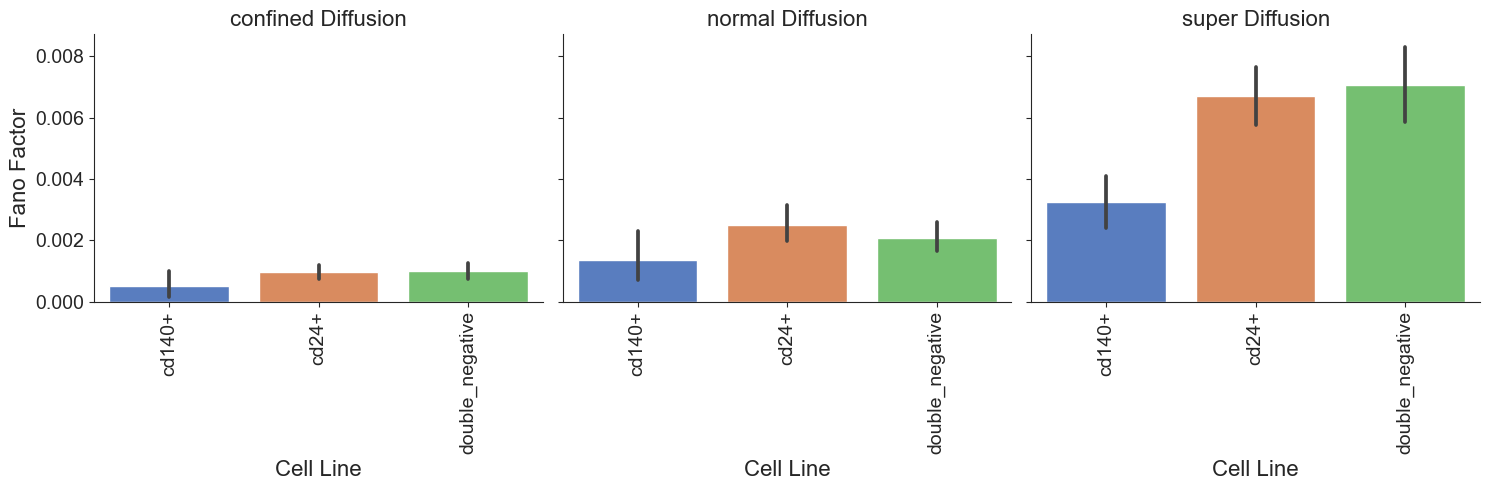

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to plot
grouped_reset = grouped.reset_index()

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Use seaborn's facet grid to create separate plots for each 'type_of_diffusion'
g = sns.FacetGrid(grouped_reset, col="type of diffusion", sharey=True, height=5)
g.map(sns.barplot, "Cell_Type", "fano_factor", palette="muted")
# Rotate x-tick labels in each facet
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Set the axis labels
g.set_axis_labels("Cell Line", "Fano Factor")
g.set_titles(col_template="{col_name} Diffusion")


# Adjust and display the plot
plt.tight_layout()
plt.show()


In [43]:
# Filter the DataFrame
filtered_df = grouped_reset[(grouped_reset['condition'] == 'RA+')]

# Add a new column combining Cell_Type, type_of_diffusion, and condition for plotting
filtered_df['Cell_Type_Diffusion_time'] = filtered_df['condition'] + filtered_df['Cell_Type'] + ' - ' + filtered_df['type of diffusion']

# Define the custom order for x-axis
custom_order = [
    'RA+double_negative - confined',
    'RA+cd24+ - confined',
    'RA+cd140+ - confined',
    'RA+double_negative - normal',
    'RA+cd24+ - normal',
    'RA+cd140+ - normal',
    'RA+double_negative - super',
    'RA+cd24+ - super',
    'RA+cd140+ - super'

]

# Convert 'Cell_Type_Diffusion_time' to a categorical variable with the custom order
filtered_df['Cell_Type_Diffusion_time'] = pd.Categorical(filtered_df['Cell_Type_Diffusion_time'], categories=custom_order, ordered=True)

# Group by the necessary columns and calculate mean and SEM
agg_df = filtered_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']).agg(
    mean_fano=('fano_factor', 'mean'),
    sem_fano=('fano_factor', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

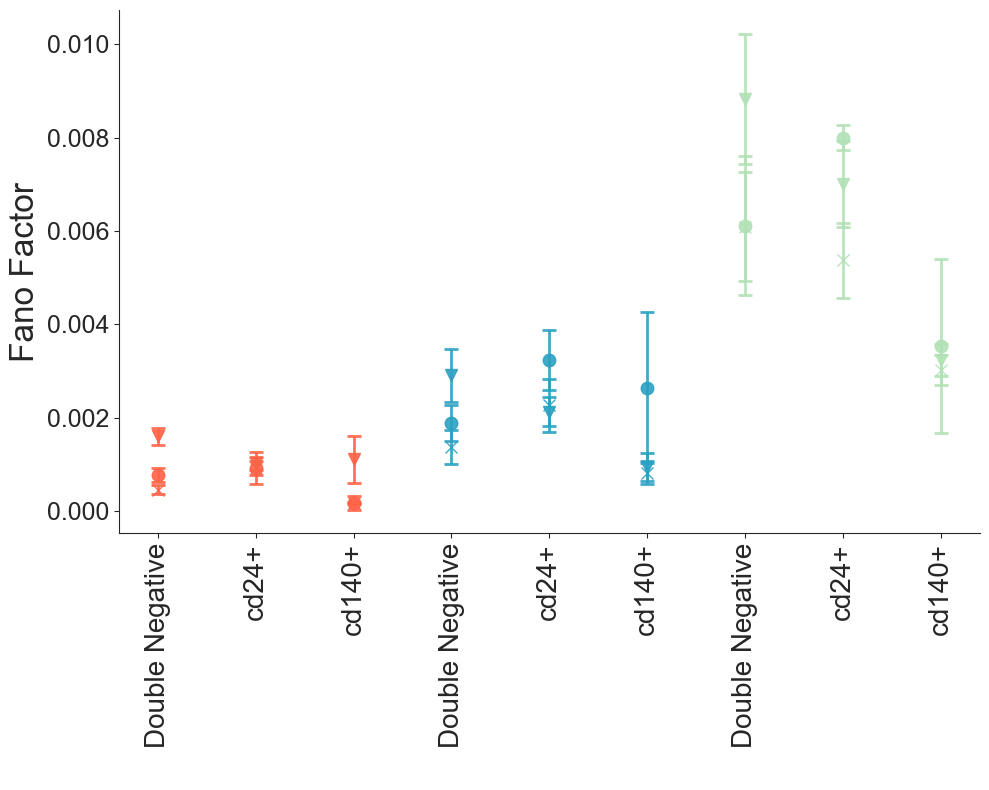

In [44]:
# Define colors and markers
color_palette = sns.color_palette("YlGnBu")
colors = {'normal': color_palette[3], 'super': color_palette[1], 'confined': 'tomato'}
markers = {'week1': 'o', 'week2': 'x', 'week3': 'v'}

# Set up the plotting area
plt.figure(figsize=(10, 8))


# Plot means and SEMs
for (name, group) in agg_df.groupby(['Cell_Type_Diffusion_time', 'type of diffusion', 'condition', 'week']):
    for i, (condition, time_group) in enumerate(group.groupby('condition')):
        plt.errorbar(
            x=time_group['Cell_Type_Diffusion_time'].cat.codes,  # Use categorical codes for x-axis positions
            y=time_group['mean_fano'],
            yerr=time_group['sem_fano'],
            fmt=markers[group['week'].iloc[0]],  # Use different markers for each week
            color=colors[group['type of diffusion'].iloc[0]],  # Use color mapping for type of diffusion
            markersize=9,
            elinewidth=2,
            capsize=5,
            capthick=2,
            alpha=0.9
        )
        
labels=["Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+", "Double Negative", "cd24+", "cd140+"]
# Set custom x-ticks
plt.xticks(ticks=np.arange(len(custom_order)), labels=labels, rotation=90, fontsize=20)
plt.yticks(fontsize=18)
# Customize the plot
plt.xlabel(' ', fontsize=20)
plt.ylabel('Fano Factor', fontsize=24)

sns.despine()
plt.tight_layout()
#plt.savefig(data_dir + 'DCoeff_lineages_RA+.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
filtered